In [66]:
!pip install scikit-learn==0.22.1

In [67]:
!pip install category_encoders==2.*
!pip install eli5
!pip install pandas-profiling==2.*
!pip install pdpbox
!pip install shap

In [0]:
import pandas as pd

In [0]:
import eli5
import re
import numpy as np
import category_encoders as ce
from eli5.sklearn import PermutationImportance
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

In [70]:
fights = pd.read_csv('fights.csv')

fights.shape

(103518, 32)

In [0]:
fights = fights.drop(columns=['blue_record_at_fight_time', 'red_record_at_fight_time'])

In [0]:
fights = fights[(fights['red_decision'] == 'W') | (fights['red_decision'] == 'L') | (fights['red_decision'] == 'D')]

In [0]:
train, test = train_test_split(fights, test_size=0.20)

In [0]:
train, val = train_test_split(train, test_size=0.20)

In [0]:
target = 'red_decision'
features = train.columns.drop([target, 'result'])

X_train = train[features]
y_train = train[target]

X_val = train[features]
y_val = train[target]

X_test = test[features]

In [76]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer()
)

X_train_transformed = pipeline.fit_transform(X_train)
X_val_transformed = pipeline.transform(X_val)
X_test_transformed = pipeline.transform(X_test)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [77]:
from sklearn.metrics import accuracy_score

rf_y_pred = model.predict(X_val_transformed)
print(accuracy_score(y_val, rf_y_pred))

1.0


In [78]:
permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [0]:
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
perm_features = X_train.columns[mask]
X_train_perm = X_train[perm_features]
X_val_perm = X_val[perm_features]
X_test_perm = X_test[perm_features]

In [80]:
from eli5.sklearn import PermutationImportance

eli5.show_weights(permuter, feature_names=X_val.columns.to_list())

Weight,Feature
0.1124 ± 0.0013,red_years_active
0.0773 ± 0.0012,red_height
0.0636 ± 0.0006,red_br_id
0.0610 ± 0.0013,red_reach
0.0609 ± 0.0002,date
0.0460 ± 0.0015,red_age
0.0384 ± 0.0009,red
0.0367 ± 0.0010,red_nationality
0.0268 ± 0.0011,red_born
0.0205 ± 0.0003,blue_br_id


In [0]:
from xgboost import XGBClassifier

encoder = ce.OrdinalEncoder().fit(X_train_perm)

X_train_encoded = encoder.transform(X_train_perm)
X_val_encoded = encoder.transform(X_val_perm)

xgb = XGBClassifier(n_estimators=100,
                    max_depth=5,
                    learning_rate=0.1,
                    random_state=42,
                    n_jobs=-1)

eval_set = [(X_train_encoded, y_train),
            (X_val_encoded, y_val)]

xgb.fit(X_train_encoded, y_train)

y_pred = xgb.predict(X_val_encoded)

In [0]:
xgb_pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=100,
                    max_depth=5,
                    learning_rate=0.1,
                    random_state=42,
                    n_jobs=-1)
)

In [83]:
from sklearn.metrics import roc_auc_score

y_pred_proba = xgb.predict_proba(X_val_encoded)
roc_auc_score(y_val, y_pred_proba, multi_class='ovo', average='macro')

0.7395134455321268

In [84]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, y_pred)  

array([[    7,   775,  2101],
       [    0, 12383, 12927],
       [    0,  4857, 32476]])

In [85]:
print(le.inverse_transform([0, 1, 2]))

['D' 'L' 'W']


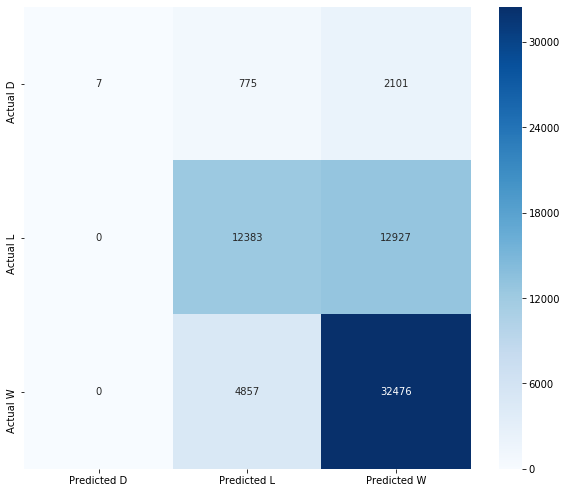

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8.5))

le.inverse_transform(y_val)

def plot_confusion_matrix(y_val, y_pred):
  labels = le.inverse_transform([0, 1, 2])
  columns = [f'Predicted {label}' for label in labels]
  index = [f'Actual {label}' for label in labels]
  df = pd.DataFrame(confusion_matrix(y_val, y_pred),
                    columns = columns,
                    index = index)
  return sns.heatmap(df, annot=True, fmt='d', cmap='Blues')

plot_confusion_matrix(y_val, y_pred);

In [87]:
# Correct win percentage calculation - we only care about when the red corner wins.

# Correct Prediction Across Classes
correct = 0 + 6996 + 26900

# Total Predictions made
actual = len(y_val)

# Classification Accuracy
correct/actual*100

51.729084638158895

In [0]:
import pickle

encoder_filename = 'encoder_pipeline.sav'

pickle.dump(encoder, open(encoder_filename, 'wb'))

model_filename = 'xgboost_boxing_model_2.sav'

pickle.dump(xgb, open(model_filename, 'wb'))

In [0]:
import pickle
from xgboost import XGBClassifier
import pandas as pd
import category_encoders as ce

loaded_model_filename = 'xgboost_boxing_model_2.sav'

loaded_model = pickle.load(open(loaded_model_filename, 'rb'))

loaded_encoder_filename = 'encoder_pipeline.sav'

loaded_encoder = pickle.load(open(loaded_encoder_filename, 'rb'))

In [0]:
X_one_fight = pd.DataFrame({'date': '2019-05-10',
                            'blue': 'Luis Alberto Lopez Vargas', 
                            'red': 'Ruben Villa', 
                            'red_br_id': 768427, 
                            'blue_br_id': '741197',
                            'title_fight': 'True',
                            'venue': 'Omega Products International, Corona',
                            'red_born': '1997-04-16',
                            'red_debut': '2016-07-29',
                            'red_division': 'feather',
                            'red_height': '168cm',
                            'red_nationality': 'USA',
                            'red_reach': '169cm',
                            'red_stance': 'southpaw',
                            'blue_born': '1993-08-21',
                            'blue_debut': '2015-11-06',
                            'blue_division': 'feather',
                            'blue_height': '163cm',
                            'blue_nationality': 'Mexico',
                            'blue_reach': '169cm',
                            'sex': 'male',
                            #'blue_stance': 'orthodox', ===> This feature was dropped during permution
                            'red_age': 22.0,
                            'blue_age': 26.0,
                            'red_age_at_fight_time': '25',
                            'red_years_active': '1155 days 00:00:00.000000000',
                            'blue_age_at_fight_time': '26',
                            'blue_years_active': '1642 days 00:00:00.000000000'},
                           index=[0])

In [0]:
encoder_filename = 'encoder_pipeline.sav'
loaded_encoder = pickle.load(open(encoder_filename, 'rb'))

X_one_fight_encoded = loaded_encoder.transform(X_one_fight)

In [100]:
loaded_model.predict_proba(X_one_fight_encoded)

array([[0.1503123 , 0.295474  , 0.55421376]], dtype=float32)

In [0]:
X_one_fight_encoded